In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import lightgbm as lgb

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

/Users/gokberk/miniconda3/envs/ml4hc_project2/lib/python3.9/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# define performance metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error

def rmse(y_true, y_pred):
    return mean_squared_error(y_true,y_pred,squared=False)

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def mape(y_true, y_pred):
    return mean_absolute_percentage_error(y_true, y_pred)

In [3]:
df = pd.read_csv('data/electric_demand/energy_dataset.csv')
df = df[['time','total load actual']]

temp_s = pd.to_datetime(df['time'])
temp_s = temp_s.apply(lambda x: x.strftime('%Y-%m-%d'))
df['time'] = temp_s

temp_df = df.groupby('time').agg('mean').reset_index()

In [4]:
train_len = 1000
valid_len = 100

forecast_horizon = 7 # forecast horizon (H)
lookback_horizon = 7 * 7 # lookback horizon (nH)

train_df = temp_df.iloc[:train_len,-1]
valid_df = temp_df.iloc[train_len-lookback_horizon:train_len+valid_len,-1]
test_df = temp_df.iloc[train_len+valid_len-lookback_horizon:,-1]

In [5]:
train_df = np.expand_dims(train_df.to_numpy(),axis=1)
valid_df = np.expand_dims(valid_df.to_numpy(),axis=1)
test_df = np.expand_dims(test_df.to_numpy(),axis=1)

# do we need scaler in n-beats?
scaler = StandardScaler()
train_df = pd.DataFrame(np.squeeze(scaler.fit_transform(train_df)))
valid_df = pd.DataFrame(np.squeeze(scaler.transform(valid_df)))
test_df = pd.DataFrame(np.squeeze(scaler.transform(test_df)))

In [6]:
def process_series(df, input_size, output_size, stride):

    X = np.empty(shape=(1,input_size))
    y = np.empty(shape=(1,output_size))

    for idx, _ in df.iterrows():
        
        if idx % stride == 0 and idx+input_size+output_size <= len(df):
            
            input_values = (df.iloc[idx:idx+input_size]).to_numpy().T

            output_values = (df.iloc[idx+input_size:idx+input_size+output_size]).to_numpy().T
            
            X = np.concatenate((X,input_values))
            y = np.concatenate((y,output_values))
    
    return X[1:],y[1:]

train_X, train_y = process_series(train_df, lookback_horizon, forecast_horizon, 1)
valid_X, valid_y = process_series(valid_df, lookback_horizon, forecast_horizon, 7)
test_X, test_y = process_series(test_df, lookback_horizon, forecast_horizon, 7)

In [7]:
import tensorflow as tf
import tensorflow.keras.layers as tfkl

class NBEATS_Block(tf.keras.Model):

    def __init__(self, width, forecast_H, lookback_H):
        super(NBEATS_Block, self).__init__()
        self.fc1 = tfkl.Dense(units=width,activation='relu',use_bias=True)
        self.fc2 = tfkl.Dense(units=width,activation='relu',use_bias=True)
        self.fc3 = tfkl.Dense(units=width,activation='relu',use_bias=True)
        self.fc4 = tfkl.Dense(units=width,activation='relu',use_bias=True)

        self.b_linear = tfkl.Dense(units=width,activation=None,use_bias=False)
        self.f_linear = tfkl.Dense(units=width,activation=None,use_bias=False)

        self.g_b = tfkl.Dense(units=lookback_H,activation=None,use_bias=True)

        self.g_f = tfkl.Dense(units=forecast_H,activation=None,use_bias=True)

    def call(self, x):

        h1 = self.fc1(x)
        h2 = self.fc2(h1)
        h3 = self.fc3(h2)
        h4 = self.fc4(h3)

        theta_b = self.b_linear(h4)
        theta_f = self.f_linear(h4)

        x_hat = self.g_b(theta_b)
        y_hat = self.g_f(theta_f)

        return x_hat, y_hat


class NBEATS_Stack(tf.keras.Model):

    def __init__(self, blocks, width, forecast_H, lookback_H):
        super(NBEATS_Stack, self).__init__()
        self.blocks = blocks

        for idx in range(self.blocks):
            setattr(self,'block'+str(idx), NBEATS_Block(width, forecast_H, lookback_H))

    def call(self, x):
        
        x_hat, y_hat = getattr(self,'block'+str(0))(x)
        x_new = x - x_hat
        y_stack = y_hat
        
        for idx in range(1,self.blocks):
            x_hat, y_hat = getattr(self,'block'+str(idx))(x_new)
            x_new -= x_hat
            y_stack += y_hat

        return x_new, y_stack


class NBEATS(tf.keras.Model):

    def __init__(self, stacks, blocks, width, forecast_H, lookback_H):
        super(NBEATS, self).__init__()
        self.stacks = stacks

        for idx in range(self.stacks):
            setattr(self,'stack'+str(idx), NBEATS_Stack(blocks, width, forecast_H, lookback_H))

    def call(self, x):
        
        x_stack, y_stack = getattr(self,'stack'+str(0))(x)
        y_total = y_stack
        
        for idx in range(1,self.stacks):
            x_stack, y_stack = getattr(self,'stack'+str(idx))(x_stack)
            y_total += y_stack
        
        return y_total

In [10]:
model = NBEATS(stacks=2, blocks=2, width=32, forecast_H=forecast_horizon, lookback_H=lookback_horizon)

loss = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)

early_stopping = tf.keras.callbacks.EarlyStopping(patience=5,verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(factor=0.2,patience=2,cooldown=3,verbose=1)

model.compile(loss=loss, optimizer=optimizer)

model.fit(x=train_X, y=train_y, epochs=10, batch_size=32, validation_data=(valid_X, valid_y), callbacks=[])

Epoch 1/10
30/30 [==============================] - 1s 10ms/step - loss: 1.0787 - val_loss: 1.0746
Epoch 2/10
30/30 [==============================] - 0s 3ms/step - loss: 0.8765 - val_loss: 0.9894
Epoch 3/10
30/30 [==============================] - 0s 4ms/step - loss: 0.7847 - val_loss: 0.9243
Epoch 4/10
30/30 [==============================] - 0s 3ms/step - loss: 0.7085 - val_loss: 0.8492
Epoch 5/10
30/30 [==============================] - 0s 3ms/step - loss: 0.6448 - val_loss: 0.8460
Epoch 6/10
30/30 [==============================] - 0s 3ms/step - loss: 0.5889 - val_loss: 0.8586
Epoch 7/10
30/30 [==============================] - 0s 3ms/step - loss: 0.5389 - val_loss: 0.8332
Epoch 8/10
30/30 [==============================] - 0s 3ms/step - loss: 0.4922 - val_loss: 0.8593
Epoch 9/10
30/30 [==============================] - 0s 3ms/step - loss: 0.4546 - val_loss: 0.8619
Epoch 10/10
30/30 [==============================] - 0s 3ms/step - loss: 0.4128 - val_loss: 0.8694


valid | MAE: 2030.09, RMSE: 2566.89, MAPE: 0.07
test  | MAE: 1984.67, RMSE: 2515.92, MAPE: 0.07


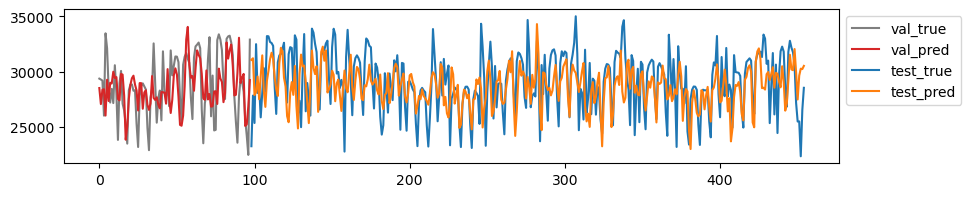

In [11]:
valid_preds = np.expand_dims(model.predict(valid_X).flatten(),0)
y_pred_valid = np.squeeze(scaler.inverse_transform(valid_preds))

y_true_valid = temp_df.iloc[train_len:train_len+len(y_pred_valid),-1].values

test_preds = np.expand_dims(model.predict(test_X).flatten(),0)
y_pred_test = np.squeeze(scaler.inverse_transform(test_preds))

y_true_test = temp_df.iloc[train_len+valid_len:train_len+valid_len+len(y_pred_test),-1].values

print(f'valid | MAE: {round(mae(y_true_valid, y_pred_valid),2)}, RMSE: {round(rmse(y_true_valid, y_pred_valid),2)}, MAPE: {round(mape(y_true_valid, y_pred_valid),2)}')
print(f'test  | MAE: {round(mae(y_true_test, y_pred_test),2)}, RMSE: {round(rmse(y_true_test, y_pred_test),2)}, MAPE: {round(mape(y_true_test, y_pred_test),2)}')

plt.figure(figsize=(10,2))
# plot valid data and pred
valid_range = np.arange(0,len(y_true_valid))
plt.plot(valid_range,y_true_valid, label='val_true', color='C7')
plt.plot(valid_range,y_pred_valid, label='val_pred', color='C3')
# plot test data and pred
test_range = np.arange(valid_range[-1]+1,len(y_true_test)+valid_range[-1]+1)
plt.plot(test_range,y_true_test, label='test_true')
plt.plot(test_range,y_pred_test, label='test_pred')
plt.legend(bbox_to_anchor=(1, 1))
plt.show()